In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import re
from nltk.tokenize import WhitespaceTokenizer

import warnings
warnings.filterwarnings('ignore')

In [136]:
filename =  '../data/tds_vectorized_jargon.csv'

In [137]:
df = pd.read_csv(filename)

In [138]:
df.head()

,claps,text,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
0,489,ultimate guide acing coding interviews data sc...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
1,139,shakespeare versus eminem— who’s better lyrici...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,8
2,133,implementing visualttransformer pytorch hi guy...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,42
3,92,stock price analysis pandas altair practical g...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
4,58,optimal threshold imbalanced classification ha...,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,145


In [139]:
X = df.drop(columns = ['claps', 'text'])
y = df['claps']

#### Look at Phrase Frequency in the Corpus

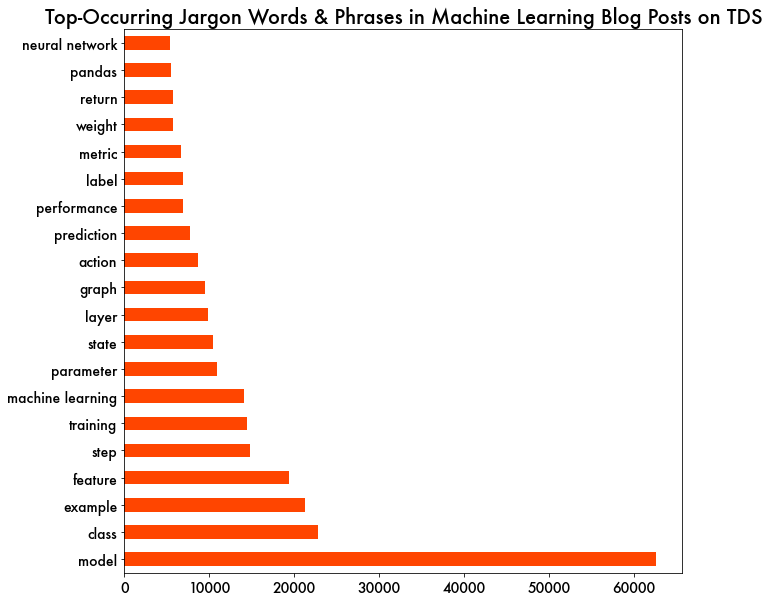

In [140]:
# plot top occurring words/phrases

#remove the total count for the plot
jargon_X = X.drop(columns='total_jargon_count')
plt.figure(figsize = (10,10))
jargon_X.sum().sort_values(ascending = False).head(20).plot(kind='barh', color='orangered');
figurefont = {'fontname' : 'Futura'}
plt.xticks(**figurefont, fontsize = 14);
plt.yticks(**figurefont, fontsize = 14);
plt.title('Top-Occurring Jargon Words & Phrases in Machine Learning Blog Posts on TDS',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_top_occurring_jargon.jpg',  bbox_inches = "tight")

### Investigation I: Effect of Quantity of Jargon on Number of Claps

In [125]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

In [126]:
model_list = [
    LinearRegression(),
    DecisionTreeRegressor(),
    BaggingRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    SVR(),
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train, y_train)
    results_dict['test_score'] = model.score(X_test, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train, y_train, cv = 5).mean()
    results_dict['train_RMSE'] = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    results_dict['test_RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(X_test))) 
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [127]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,train_RMSE,test_RMSE
0,LinearRegression(),0.050922,-1.977260e+15,-2.050401e+16,111.970824,5.359299e+09
1,DecisionTreeRegressor(),0.992898,-7.998183e-01,-9.163731e-01,9.685757,1.616927e+02
2,BaggingRegressor(),0.799927,-9.990029e-02,-1.057715e-01,51.410123,1.264016e+02
3,RandomForestRegressor(),0.853331,-1.007669e-02,-3.686688e-02,44.017211,1.211304e+02
4,AdaBoostRegressor(),-0.447212,-3.772466e-01,-5.863838e-01,138.267493,1.414432e+02
5,SVR(),-0.113335,-1.160215e-01,-1.155179e-01,121.273778,1.273246e+02


These are very poor results. 

### Investigation II: Effect of Proportion of Jargon on Number of Claps

In [110]:
df['total_jargon_count'].head()

0     20
1      8
2     42
3     19
4    145
Name: total_jargon_count, dtype: int64

In [111]:
#read in preprocessed abstracts to get total word count
tds = pd.read_csv('../data/nlp_nltk_stemmed_preproc.csv').drop(columns = 'Unnamed: 0')

In [112]:
#remove punctuation characters 
tds['text'] = tds['text'].replace("[''·,\.!?'-]",'',regex=True)
#remove brackets surrounding the text
tds['text'] = tds['text'].map(lambda x: x.replace("[",""))
tds['text'] = tds['text'].map(lambda x: x.replace("]",""))

In [113]:
#tokenize text into lists to get word count
w_tokenizer = WhitespaceTokenizer()
tds['words'] = tds['text'].apply(lambda x: w_tokenizer.tokenize(x))
tds['word_count'] = tds['words'].apply(lambda x: len(x))

In [114]:
#get both dataframes in the same order
df = df.sort_values(by = ['claps', 'text'], ascending=False)
tds = tds.sort_values(by = ['claps', 'text'], ascending=False)

In [119]:
# calculate word count, jargon count, and jargon proportion 
jargon_count = df['total_jargon_count']
jargon_prop = (jargon_count/tds['word_count'])

#Create new dataframe with jargon prop and citations
prop = pd.DataFrame()
prop['jargon_prop'] = pd.Series(jargon_prop)
prop['claps'] = df['claps']

In [120]:
# calculate correlation
prop['claps'].corr(prop['jargon_prop'])

-0.019451315166617265

Confirmed that the proportion of machine learning jargon is not correlated with the number of claps.

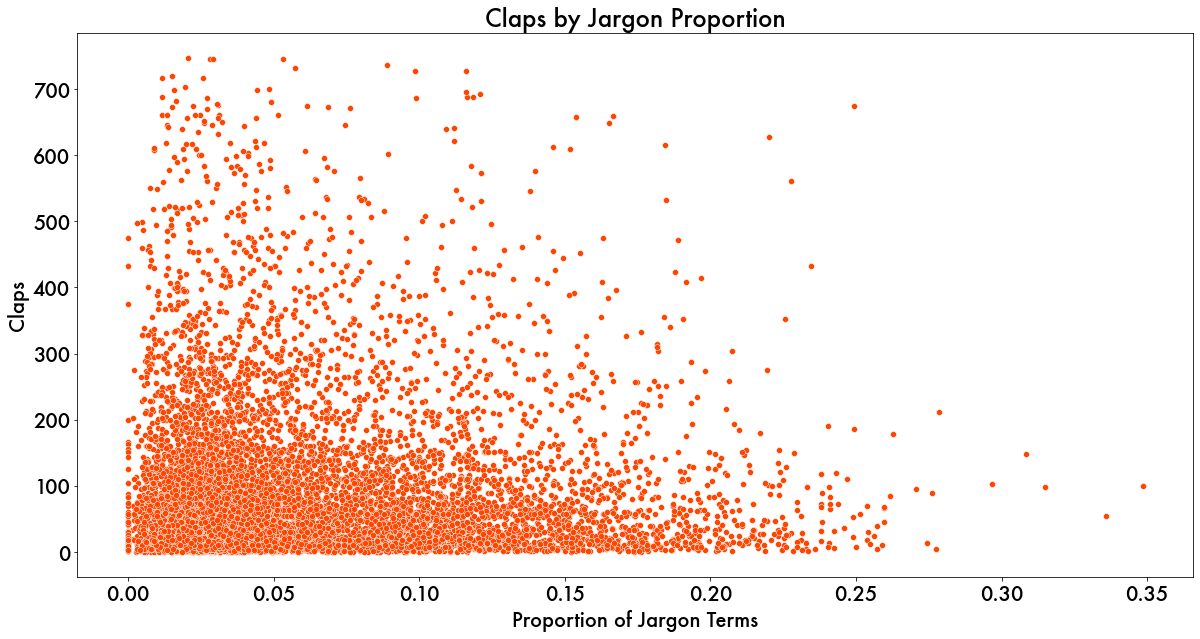

In [141]:
plt.figure(figsize = (20, 10));
sns.scatterplot(data=prop, x='jargon_prop', y='claps', color ='orangered');
figurefont = {'fontname' : 'Futura'};
plt.title('Claps by Jargon Proportion', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Proportion of Jargon Terms',**figurefont, fontsize = 20);
plt.ylabel('Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_claps_jargon_prop_scatterplot.jpg',  bbox_inches = "tight")